# 4장. 좋은 훈련 세트 만들기: 데이터 전처리

**아래 링크를 통해 이 노트북을 주피터 노트북 뷰어(nbviewer.jupyter.org)로 보거나 구글 코랩(colab.research.google.com)에서 실행할 수 있습니다.**

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.jupyter.org/github/rickiepark/python-machine-learning-book-2nd-edition/blob/master/code/ch04/ch04.ipynb"><img src="https://jupyter.org/assets/main-logo.svg" width="28" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/python-machine-learning-book-2nd-edition/blob/master/code/ch04/ch04.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

`watermark`는 주피터 노트북에 사용하는 파이썬 패키지를 출력하기 위한 유틸리티입니다. `watermark` 패키지를 설치하려면 다음 셀의 주석을 제거한 뒤 실행하세요.

In [1]:
#!pip install watermark

In [2]:
%load_ext watermark
%watermark -u -d -p numpy,pandas,matplotlib,sklearn

last updated: 2019-12-29 

numpy 1.16.3
pandas 0.24.2
matplotlib 3.0.3
sklearn 0.22


# 누락된 데이터 다루기

## 테이블 형태 데이터에서 누락된 값 식별하기

In [3]:
import pandas as pd
from io import StringIO

csv_data = \
'''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''

# 파이썬 2.7을 사용하는 경우
# 다음처럼 문자열을 유니코드로 변환해야 합니다.
# csv_data = unicode(csv_data)

df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [4]:
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

In [5]:
# `values` 속성으로 넘파이 배열을 얻을 수 있습니다.
df.values

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

## 누락된 값이 있는 샘플이나 특성을 제외하기

In [6]:
# 누락된 값이 있는 행을 삭제합니다.

df.dropna(axis=0)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [7]:
# 누락된 값이 있는 열을 삭제합니다.

df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


In [8]:
# 모든 값이 누락된 행을 삭제합니다.

df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


In [9]:
# 모든 열이 NaN일 때만 행을 삭제합니다.

df.dropna(how='all')  

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [10]:
# 실수 값이 4개보다 작은 행을 삭제합니다

df.dropna(thresh=4)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [11]:
# 특정 열에 NaN이 있는 행만 삭제합니다(여기서는 ‘C’열).

df.dropna(subset=['C'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


## 누락된 값을 대체하기

In [12]:
# 원본 배열
df.values

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

In [13]:
# 사이킷런 0.22 버전에서 Imputer 클래스가 삭제되었습니다. 대신 SimpleImputer를 사용하세요.

# 누락된 값을 열의 평균으로 대체합니다.

#from sklearn.preprocessing import Imputer

#imr = Imputer(missing_values='NaN', strategy='mean', axis=0)
#imr = imr.fit(df.values)
#imputed_data = imr.transform(df.values)
#imputed_data

ImportError: cannot import name 'Imputer' from 'sklearn.preprocessing' (/home/haesun/anaconda3/envs/python-ml/lib/python3.7/site-packages/sklearn/preprocessing/__init__.py)

역자노트 #####

In [14]:
import numpy as np
from sklearn.impute import SimpleImputer

simr = SimpleImputer(missing_values=np.nan, strategy='mean')
simr = simr.fit(df.values)
imputed_data = simr.transform(df.values)
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

In [15]:
from sklearn.preprocessing import FunctionTransformer
ftr_simr = FunctionTransformer(lambda X: simr.fit_transform(X.T).T, validate=False)
imputed_data = ftr_simr.fit_transform(df.values)
imputed_data

array([[ 1.        ,  2.        ,  3.        ,  4.        ],
       [ 5.        ,  6.        ,  6.33333333,  8.        ],
       [10.        , 11.        , 12.        , 11.        ]])

#####

# 범주형 데이터 다루기

## 순서가 있는 특성과 순서가 없는 특성

In [16]:
import pandas as pd

df = pd.DataFrame([['green', 'M', 10.1, 'class1'],
                   ['red', 'L', 13.5, 'class2'],
                   ['blue', 'XL', 15.3, 'class1']])

df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


## 순서 특성 매핑하기

In [17]:
size_mapping = {'XL': 3,
                'L': 2,
                'M': 1}

df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


In [18]:
inv_size_mapping = {v: k for k, v in size_mapping.items()}
df['size'].map(inv_size_mapping)

0     M
1     L
2    XL
Name: size, dtype: object

## 클래스 레이블 인코딩

In [19]:
import numpy as np

# 문자열 클래스 레이블을 정수로 변환하기 위해
# 매핑 딕셔너리를 만듭니다.
class_mapping = {label: idx for idx, label in enumerate(np.unique(df['classlabel']))}
class_mapping

{'class1': 0, 'class2': 1}

In [20]:
# 문자열 클래스 레이블을 정수로 변환합니다.
df['classlabel'] = df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,0
1,red,2,13.5,1
2,blue,3,15.3,0


In [21]:
# 클래스 레이블 매핑을 거꾸로 수행합니다.
inv_class_mapping = {v: k for k, v in class_mapping.items()}
df['classlabel'] = df['classlabel'].map(inv_class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


In [22]:
from sklearn.preprocessing import LabelEncoder

# 사이킷런의 LabelEncoder를 사용하여 레이블을 인코딩합니다.
class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
y

array([0, 1, 0])

In [23]:
# 거꾸로 매핑합니다.
class_le.inverse_transform(y)

array(['class1', 'class2', 'class1'], dtype=object)

## 순서가 없는 특성에 원-핫 인코딩 적용하기

In [24]:
X = df[['color', 'size', 'price']].values

color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])
X

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

역자노트 #####

In [25]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder(dtype=np.int)
col_trans = ColumnTransformer([('ord_enc', ord_enc, ['color'])])
X_trans = col_trans.fit_transform(df)
X_trans

array([[1],
       [2],
       [0]])

In [26]:
col_trans.named_transformers_['ord_enc'].inverse_transform(X_trans)

array([['green'],
       ['red'],
       ['blue']], dtype=object)

#####

In [27]:
# 사이킷런 0.22 버전에서 categorical_features 매개변수가 삭제되었습니다.
# 대신 categories 매개변수를 사용하세요.

#from sklearn.preprocessing import OneHotEncoder

#ohe = OneHotEncoder(categorical_features=[0])
#ohe.fit_transform(X).toarray()

TypeError: __init__() got an unexpected keyword argument 'categorical_features'

역자노트 #####

In [32]:
oh_enc = OneHotEncoder(categories='auto')
col_trans = ColumnTransformer([('oh_enc', oh_enc, [0])], remainder='passthrough')
col_trans.fit_transform(X)

array([[0.0, 1.0, 0.0, 1, 10.1],
       [0.0, 0.0, 1.0, 2, 13.5],
       [1.0, 0.0, 0.0, 3, 15.3]], dtype=object)

#####

In [33]:
# sparse=False로 지정하면 toarray 메서드를 사용하지 않고 밀집 배열을 얻을 수 있습니다.

ohe = OneHotEncoder(categorical_features=[0], sparse=False)
ohe.fit_transform(X)

TypeError: __init__() got an unexpected keyword argument 'categorical_features'

In [34]:
# 판다스의 원-핫 인코딩

pd.get_dummies(df[['price', 'color', 'size']])

,price,size,color_blue,color_green,color_red
0,10.1,1,0,1,0
1,13.5,2,0,0,1
2,15.3,3,1,0,0


역주 #####

In [35]:
pd.get_dummies(df[['price', 'color', 'size']], columns=['size'])

,price,color,size_1,size_2,size_3
0,10.1,green,1,0,0
1,13.5,red,0,1,0
2,15.3,blue,0,0,1


#####

In [36]:
# get_dummies에서 다중 공선성 문제를 피하려면

pd.get_dummies(df[['price', 'color', 'size']], drop_first=True)

,price,size,color_green,color_red
0,10.1,1,1,0
1,13.5,2,0,1
2,15.3,3,0,0


In [37]:
# OneHotEncoder에서 다중 공선성 문제를 피하려면

ohe = OneHotEncoder(categorical_features=[0])
ohe.fit_transform(X).toarray()[:, 1:]

TypeError: __init__() got an unexpected keyword argument 'categorical_features'

# 데이터셋을 훈련 세트와 테스트 세트로 나누기

In [38]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/wine/wine.data',
                      header=None)

# UCI 머신 러닝 저장소에서 Wine 데이터셋을 다운로드할 수 없을 때
# 다음 주석을 해제하고 로컬 경로에서 데이터셋을 적재하세요.

# df_wine = pd.read_csv('wine.data', header=None)


df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

print('클래스 레이블', np.unique(df_wine['Class label']))
df_wine.head()

클래스 레이블 [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [39]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)

# 특성 스케일 맞추기

In [40]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

In [41]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

간단한 예제

In [42]:
ex = np.array([0, 1, 2, 3, 4, 5])

print('표준화:', (ex - ex.mean()) / ex.std())

# 판다스는 기본적으로 ddof=1(샘플 표준 편차)을 사용합니다.
# 넘파이의 std 메서드와 사이킷런의 StandardScaler는 ddof=0(모집단 표준 편차)를 사용합니다.

print('정규화:', (ex - ex.min()) / (ex.max() - ex.min()))

표준화: [-1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011]
정규화: [0.  0.2 0.4 0.6 0.8 1. ]


# 유용한 특성 선택하기

## Sparse solutions with L1-regularization

사이킷런에서 L1 규제를 지원하는 모델은 `penalty` 매개변수를 `‘l1’`으로 지정하여 희소한 모델을 만들 수 있습니다:

In [43]:
from sklearn.linear_model import LogisticRegression
LogisticRegression(solver='liblinear', penalty='l1')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

표준화 처리된 Wine 데이터셋에 적용해 보겠습니다.

In [44]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='liblinear', multi_class='auto', 
                        penalty='l1', C=1.0, random_state=42)
# C=1.0이 기본값입니다. 값을 증가시키거나 줄여서 
# 규제 효과를 크게 또는 약하게 할 수 있습니다.
lr.fit(X_train_std, y_train)
print('훈련 정확도:', lr.score(X_train_std, y_train))
print('테스트 정확도:', lr.score(X_test_std, y_test))

훈련 정확도: 1.0
테스트 정확도: 1.0


In [45]:
lr.intercept_

array([-1.26341605, -1.21598985, -2.3701943 ])

In [46]:
np.set_printoptions(8)

In [47]:
lr.coef_[lr.coef_!=0].shape

(23,)

In [48]:
lr.coef_

array([[ 1.24579421,  0.18061164,  0.74359352, -1.16112462,  0.        ,
         0.        ,  1.16957619,  0.        ,  0.        ,  0.        ,
         0.        ,  0.54788874,  2.51037422],
       [-1.53699942, -0.38746609, -0.99525191,  0.36498543, -0.05970899,
         0.        ,  0.6678873 ,  0.        ,  0.        , -1.93417045,
         1.23366592,  0.        , -2.23177895],
       [ 0.13562632,  0.16843221,  0.3572171 ,  0.        ,  0.        ,
         0.        , -2.43829335,  0.        ,  0.        ,  1.56374546,
        -0.81900707, -0.49232727,  0.        ]])

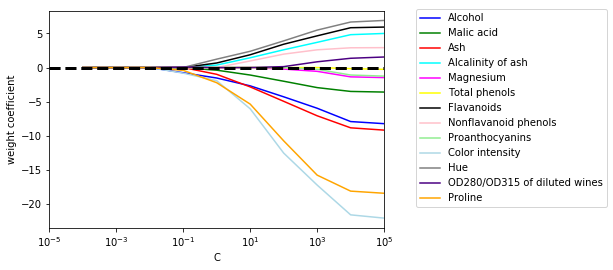

In [49]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)
    
colors = ['blue', 'green', 'red', 'cyan', 
          'magenta', 'yellow', 'black', 
          'pink', 'lightgreen', 'lightblue', 
          'gray', 'indigo', 'orange']

weights, params = [], []
for c in np.arange(-4., 6.):
    lr = LogisticRegression(solver='liblinear', multi_class='auto',
                            penalty='l1', C=10.**c, random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=df_wine.columns[column + 1],
             color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', 
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)
plt.show()

## 순차 특성 선택 알고리즘

In [50]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

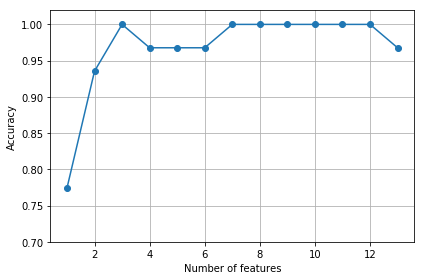

In [51]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

# 특성을 선택합니다.
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

# 특성 조합의 성능 그래프를 출력합니다.
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

In [52]:
k3 = list(sbs.subsets_[10])
print(df_wine.columns[1:][k3])

Index(['Alcohol', 'Malic acid', 'OD280/OD315 of diluted wines'], dtype='object')


In [53]:
knn.fit(X_train_std, y_train)
print('훈련 정확도:', knn.score(X_train_std, y_train))
print('테스트 정확도:', knn.score(X_test_std, y_test))

훈련 정확도: 0.967741935483871
테스트 정확도: 0.9629629629629629


In [54]:
knn.fit(X_train_std[:, k3], y_train)
print('훈련 정확도:', knn.score(X_train_std[:, k3], y_train))
print('테스트 정확도:', knn.score(X_test_std[:, k3], y_test))

훈련 정확도: 0.9516129032258065
테스트 정확도: 0.9259259259259259


# 랜덤 포레스트의 특성 중요도 사용하기

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
 6) Hue                            0.058739
 7) Total phenols                  0.050872
 8) Magnesium                      0.031357
 9) Malic acid                     0.025648
10) Proanthocyanins                0.025570
11) Alcalinity of ash              0.022366
12) Nonflavanoid phenols           0.013354
13) Ash                            0.013279


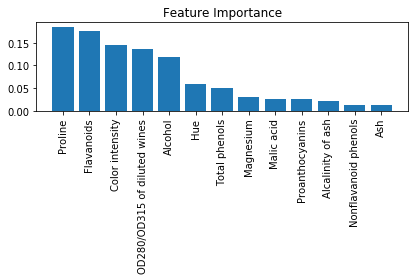

In [55]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [56]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest, threshold=0.1, prefit=True)
X_selected = sfm.transform(X_train)
print('이 임계 조건을 만족하는 샘플의 수:', X_selected.shape[1])

이 임계 조건을 만족하는 샘플의 수: 5


앞서 정의한 특성 선택 임계 조건을 만족하는 특성을 출력해 보겠습니다:

In [57]:
for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
